In [1]:
%load_ext lab_black

In [2]:
import warnings

import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# The numerical data

This notebook is dedicated to reading in, formatting, and combining the different sources of numerical data. First, inlfation data is read in.

In [3]:
with warnings.catch_warnings(record=True):
    warnings.simplefilter("always")
    one_month_inflation = pd.read_excel("../data/inflation_1_month.xlsx", header=11)
    two_month_inflation = pd.read_excel("../data/inflation_2_month.xlsx", header=11)
    three_month_inflation = pd.read_excel("../data/inflation_3_month.xlsx", header=11)
    six_month_inflation = pd.read_excel("../data/inflation_6_month.xlsx", header=11)
    twelve_month_inflation = pd.read_excel("../data/inflation_12_month.xlsx", header=11)

The data is formatted with month names, so it must be converted to a more standard YYYYMMDD date string.

In [4]:
months = [
    "Jan",
    "Feb",
    "Mar",
    "Apr",
    "May",
    "Jun",
    "Jul",
    "Aug",
    "Sep",
    "Oct",
    "Nov",
    "Dec",
]


# function to format dates and column names in each inflation df
def format_inflation_table(table, months, scale):
    inflation_formatted = []
    for idx, row in table.iterrows():
        year = int(row["Year"])
        for n, month in enumerate(months):
            inflation_formatted.append([f"{year}-{n + 1}-01", row[month]])

    formatted = pd.DataFrame(
        inflation_formatted, columns=["date", f"inflation_{scale}"]
    )

    formatted["date"] = pd.to_datetime(formatted["date"])

    formatted = formatted.set_index("date")

    return formatted


# iterate through all inflation data and format the tables, then combine them
inflation_table = pd.concat(
    [
        eval(f"format_inflation_table({scale}_inflation, months, '{scale}')")
        for scale in [
            "one_month",
            "two_month",
            "three_month",
            "six_month",
            "twelve_month",
        ]
    ],
    axis=1,
    join="inner",
)

In [5]:
inflation_table

,inflation_one_month,inflation_two_month,inflation_three_month,inflation_six_month,inflation_twelve_month
date,,,,,
1990-01-01,0.4,0.5,0.8,2.3,4.4
1990-02-01,0.6,1.0,1.1,2.7,4.6
1990-03-01,0.8,1.4,1.8,3.0,4.9
1990-04-01,0.2,1.1,1.7,2.5,4.8
1990-05-01,0.1,0.4,1.2,2.4,4.8
...,...,...,...,...,...
2022-08-01,0.5,0.8,1.6,3.2,6.3
2022-09-01,0.4,0.9,1.3,3.2,6.6
2022-10-01,0.3,0.7,1.2,2.9,6.3


Next, we read in oil price data. Minor formatting was needed to get coluns appropriately named and the date set as the index.

In [6]:
opec_price = pd.read_xml("../data/opec_basket_prices.xml", names=["date", "opec_price"])
opec_price["date"] = pd.to_datetime(opec_price["date"])
opec_price = opec_price.set_index("date")

brent_price = pd.read_csv("../data/brent_price.csv", header=4)
brent_price["date"] = pd.to_datetime(brent_price["Week of"])
brent_price = brent_price.drop(columns=["Week of"])
brent_price = brent_price.rename(
    columns={"Weekly Europe Brent Spot Price FOB Dollars per Barrel": "brent_price"}
)
brent_price = brent_price.set_index("date")

brent_price = pd.read_csv("../data/brent_price.csv", header=4)
brent_price["date"] = pd.to_datetime(brent_price["Week of"])
brent_price = brent_price.drop(columns=["Week of"])
brent_price = brent_price.rename(
    columns={"Weekly Europe Brent Spot Price FOB Dollars per Barrel": "brent_price"}
)
brent_price = brent_price.set_index("date")

wti_price = pd.read_csv("../data/wti_price.csv", header=4)
wti_price["date"] = pd.to_datetime(wti_price["Week of"])
wti_price = wti_price.drop(columns=["Week of"])
wti_price = wti_price.rename(
    columns={"Weekly Cushing OK WTI Spot Price FOB Dollars per Barrel": "wti_price"}
)
wti_price = wti_price.set_index("date")

Next, the gas prices. Like the oil tables, columns only had to be renamed and the index set.

In [7]:
gas_price = pd.read_csv("../data/gas_prices.csv", header=4)
gas_price["date"] = pd.to_datetime(gas_price["Week of"])
gas_price = gas_price.drop(columns=["Week of"])
gas_price = gas_price.rename(
    columns={
        "Weekly U.S. All Grades All Formulations Retail Gasoline Prices Dollars per Gallon": "gas_price"
    }
)
gas_price = gas_price.set_index("date")
gas_price

,gas_price
date,
2023-01-16,3.416
2023-01-09,3.366
2023-01-02,3.331
2022-12-26,3.203
2022-12-19,3.234
...,...
1993-05-03,1.086
1993-04-26,1.086
1993-04-19,1.079


Lastly, the proved oil reserves had to be loaded in. This data proved to be a bit harder to work with, as not only did the dates have to be formatted properly, but the reserve data is yearly. This means that in order to use it, the data had to be inferred for dates not specified. The obvious tactic would be to simply fill unknown weeks with the value at the start of the year, however this would make the feature more or less useless, because it only changes every 52 points. Therefore, I used a linear projection from the rate of oil gain/loss in the previous year.

In [8]:
# read in the data
proved_reserves = pd.read_csv("../data/oil-proved-reserves.csv")
proved_reserves = (
    pd.pivot_table(
        proved_reserves,
        values=["Oil - Proved reserves"],
        index=["Year"],
        columns=["Entity"],
    )
    .reset_index()["Oil - Proved reserves"]
    .reset_index()
)

# add the zero-based index to the first year in the data, 1982
proved_reserves["date"] = pd.to_datetime(
    (proved_reserves["index"] + 1982).astype(str) + "-01-01"
)
# set the index
proved_reserves = (
    proved_reserves.set_index("date").dropna(axis=1).drop(columns=["index"])
)

In [9]:
# create a full array of dates for the year
# skips leap days, but this is an approximation
# so that isn't a big deal
full_dates = sorted(
    [
        date + pd.to_timedelta(d * 60 * 60 * 1e9 * 24)
        for d in range(365)
        for date in proved_reserves.index
    ]
)
# create a list of 0-365 for as many times as there are years in the reserve data
num_days = [d for _ in range(len(proved_reserves)) for d in range(365)]
for_oil_calc = pd.DataFrame({"date": full_dates, "num_days": num_days}).set_index(
    "date"
)

# approximate a constant rate of oil production
assumed_rate = proved_reserves.diff() / 365.0

# multiply the date index by the assumed rate to calculate change
country_rates = pd.concat([for_oil_calc, assumed_rate], join="outer", axis=1).ffill()
delta = country_rates.multiply(country_rates["num_days"], axis=0)

# calculate assumed amount of oil for given day
assumed_reserves = (
    pd.concat([for_oil_calc, proved_reserves], join="outer", axis=1).ffill() + delta
).drop(columns=["num_days"])

assumed_reserves = assumed_reserves.rename(
    columns={col: f"oil_reserves_{col}" for col in assumed_reserves.columns}
)
assumed_reserves

,oil_reserves_Africa,oil_reserves_Africa (BP),oil_reserves_Algeria,oil_reserves_Angola,oil_reserves_Argentina,oil_reserves_Asia,oil_reserves_Asia Pacific (BP),oil_reserves_Australia,oil_reserves_Brazil,oil_reserves_Brunei,...,oil_reserves_Trinidad and Tobago,oil_reserves_Tunisia,oil_reserves_United Arab Emirates,oil_reserves_United Kingdom,oil_reserves_United States,oil_reserves_Upper-middle-income countries,oil_reserves_Venezuela,oil_reserves_Vietnam,oil_reserves_World,oil_reserves_Yemen
date,,,,,,,,,,,,,,,,,,,,,
1982-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1982-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1982-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1982-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1982-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,1.707658e+10,1.707658e+10,1.664080e+09,1.061601e+09,338641303.0,1.250652e+11,6.134061e+09,326042648.8,1.520347e+09,150040000.0,...,33142744.8,57970000.0,1.333992e+10,341000000.0,9.378455e+09,5.390967e+10,4.143911e+10,600160000.0,2.359659e+11,409200000.0
2022-12-28,1.707661e+10,1.707661e+10,1.664080e+09,1.061601e+09,338641303.0,1.250651e+11,6.133990e+09,326042648.8,1.520052e+09,150040000.0,...,33142744.8,57970000.0,1.333992e+10,341000000.0,9.378455e+09,5.390938e+10,4.143911e+10,600160000.0,2.359650e+11,409200000.0
2022-12-29,1.707664e+10,1.707664e+10,1.664080e+09,1.061601e+09,338641303.0,1.250651e+11,6.133919e+09,326042648.8,1.519757e+09,150040000.0,...,33142744.8,57970000.0,1.333992e+10,341000000.0,9.378455e+09,5.390909e+10,4.143911e+10,600160000.0,2.359641e+11,409200000.0


In [10]:
# join all tables together by date
table = pd.concat(
    [inflation_table, opec_price, brent_price, wti_price, assumed_reserves, gas_price],
    axis=1,
    join="outer",
)

# forward fill NaNs created by outer join
table = table.sort_values("date")
table = table.ffill()

# group by week and select the first row for that week
per_week_grouper = pd.Grouper(key="date", freq="W-MON")
table = table.reset_index()
table = table.groupby(per_week_grouper).first()
table = table[~table["gas_price"].isna()]

In [11]:
def format_column_name(name):
    name = name.lower()
    name = name.replace(" ", "_")
    name = name.replace("-", "_")
    name = name.replace("(", "").replace(")", "")
    return name


table = table.rename(columns={col: format_column_name(col) for col in table.columns})

In [12]:
# opec price has some extra nans, so we fill those with the mean of the other two oils for that week
# oil prices tend to be bery similar, so this is a good choice
table["opec_price"] = table["opec_price"].fillna(
    table[["brent_price", "wti_price"]].mean(axis=1)
)
table

,inflation_one_month,inflation_two_month,inflation_three_month,inflation_six_month,inflation_twelve_month,opec_price,brent_price,wti_price,oil_reserves_africa,oil_reserves_africa_bp,...,oil_reserves_tunisia,oil_reserves_united_arab_emirates,oil_reserves_united_kingdom,oil_reserves_united_states,oil_reserves_upper_middle_income_countries,oil_reserves_venezuela,oil_reserves_vietnam,oil_reserves_world,oil_reserves_yemen,gas_price
date,,,,,,,,,,,,,,,,,,,,,
1993-04-05,0.4,1.0,1.5,2.2,3.4,19.210,18.42,20.00,8.288873e+09,8.288874e+09,...,1.062414e+07,1.338084e+10,5.726978e+08,4.329006e+09,4.374194e+10,8.630661e+09,3.402676e+07,1.487027e+11,2.744929e+08,1.068
1993-04-12,0.2,0.6,1.2,1.8,3.5,19.585,18.73,20.44,8.293179e+09,8.293180e+09,...,7.123817e+06,1.338084e+10,5.730902e+08,4.324575e+09,4.391546e+10,8.637450e+09,3.412943e+07,1.488909e+11,2.745190e+08,1.068
1993-04-19,0.2,0.6,1.2,1.8,3.5,19.540,18.71,20.37,8.297486e+09,8.297486e+09,...,3.623494e+06,1.338084e+10,5.734826e+08,4.320144e+09,4.408898e+10,8.644238e+09,3.423210e+07,1.490791e+11,2.745452e+08,1.079
1993-04-26,0.2,0.6,1.2,1.8,3.5,19.475,18.67,20.28,8.301792e+09,8.301792e+09,...,1.231711e+05,1.338084e+10,5.738750e+08,4.315712e+09,4.426250e+10,8.651026e+09,3.433478e+07,1.492673e+11,2.745713e+08,1.079
1993-05-03,0.2,0.6,1.2,1.8,3.5,19.255,18.56,19.95,8.306098e+09,8.306099e+09,...,-3.377152e+06,1.338084e+10,5.742674e+08,4.311281e+09,4.443602e+10,8.657814e+09,3.443745e+07,1.494555e+11,2.745975e+08,1.086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26,0.2,0.3,0.6,1.8,5.7,78.130,80.80,75.12,1.707636e+10,1.707636e+10,...,5.797000e+07,1.333992e+10,3.410000e+08,9.378455e+09,5.391168e+10,4.143911e+10,6.001600e+08,2.359723e+11,4.092000e+08,3.234
2023-01-02,0.2,0.3,0.6,1.8,5.7,82.230,80.68,77.28,1.707658e+10,1.707658e+10,...,5.797000e+07,1.333992e+10,3.410000e+08,9.378455e+09,5.390967e+10,4.143911e+10,6.001600e+08,2.359659e+11,4.092000e+08,3.203
2023-01-09,0.2,0.3,0.6,1.8,5.7,82.050,81.83,79.23,1.707670e+10,1.707671e+10,...,5.797000e+07,1.333992e+10,3.410000e+08,9.378455e+09,5.390852e+10,4.143911e+10,6.001600e+08,2.359623e+11,4.092000e+08,3.331


There are currently quite a lot of features, many of which are likely useless. To get a simple metric on which features are worth keeping, I will create a basic LASSO regression and infer feature importance from that. As gas prices are largely based on oil prices, a strong linear relationship is expected.

0.9822651677230296

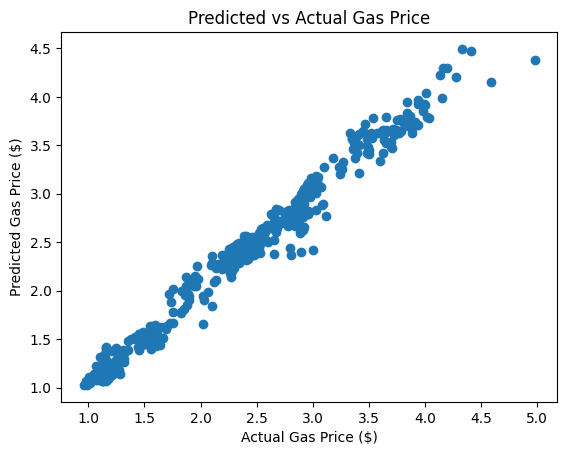

In [13]:
import matplotlib.pyplot as plt

from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

target = "gas_price"
features = [col for col in table.columns if col != target]

X, y = table[features], table[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

lr = Lasso(alpha=0.01)
model = lr.fit(X_train, y_train)

y_pred = model.predict(X_test)
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Gas Price ($)")
plt.ylabel("Predicted Gas Price ($)")
plt.title("Predicted vs Actual Gas Price")
model.score(X_test, y_test)

In [14]:
sorter = np.argsort(model.coef_)
for i in sorter:
    print(features[i], model.coef_[i])

oil_reserves_indonesia -0.016726453927714463
inflation_one_month -0.0024037812746155953
oil_reserves_iraq 0.0
oil_reserves_world 0.0
oil_reserves_low_income_countries 0.0
oil_reserves_malaysia 0.0
oil_reserves_mexico -0.0
oil_reserves_non_oecd_bp 0.0
oil_reserves_north_america 0.0
oil_reserves_north_america_bp 0.0
oil_reserves_norway -0.0
oil_reserves_oecd_bp 0.0
oil_reserves_oceania -0.0
oil_reserves_oman 0.0
oil_reserves_peru 0.0
oil_reserves_qatar 0.0
oil_reserves_saudi_arabia 0.0
oil_reserves_south_america 0.0
oil_reserves_south_and_central_america_bp 0.0
oil_reserves_sudan -0.0
oil_reserves_syria 0.0
oil_reserves_thailand 0.0
oil_reserves_total_non_opec_bp 0.0
oil_reserves_trinidad_and_tobago 0.0
oil_reserves_tunisia 0.0
oil_reserves_united_arab_emirates -0.0
oil_reserves_united_kingdom -0.0
oil_reserves_upper_middle_income_countries 0.0
oil_reserves_venezuela 0.0
oil_reserves_romania -0.0
oil_reserves_india -0.0
oil_reserves_italy -0.0
oil_reserves_gabon 0.0
inflation_two_month -

A few notes:

* Most of the reserves columns are completely useless and will be dropped
* Some of the inflation columns are considered useless by this metric, but they will be kept for feature engineering
* OPEC is price is considered useless, but this is due to the way missing values were filled. By using the mean of two other columns, this data was colinear with the other oil prices for the filled weeks

In [15]:
# all of the columns worth keeping are defined here
to_keep = [
    "inflation_one_month",
    "inflation_two_month",
    "inflation_three_month",
    "inflation_six_month",
    "inflation_twelve_month",
    "oil_reserves_algeria",
    "oil_reserves_kuwait",
    "oil_reserves_united_states",
    "oil_reserves_middle_east_bp",
    "oil_reserves_iran",
    "oil_reserves_vietnam",
    "oil_reserves_lower_middle_income_countries",
    "oil_reserves_nigeria",
    "oil_reserves_libya",
    "oil_reserves_congo",
    "opec_price",
    "wti_price",
    "brent_price",
    "gas_price",
]

In [16]:
table = table[to_keep]
table.to_csv("../data/combined.csv")